# Residual creation
In this notebook I will work on creating the residual portfolios based on the historical price dataset.

In [2]:
import pandas as pd
import datetime as dt
import numpy as np
from numpy.linalg import eig, norm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import time

In [3]:
import os
filename = 'price_df.csv'
if os.path.exists(filename):
    price_df = pd.read_csv(filename)
    price_df = price_df.rename(columns={'Unnamed: 0':'date'})
    price_df.set_index('date', inplace=True)
    price_df.index = pd.to_datetime(price_df.index)

returns = price_df.diff(1)

In [4]:
returns.shape

(6998, 966)

In [180]:
returns

,INCLF,NUE,CAT,VRSN,CVC,ODFL,QEP,TWC,RTX,FPC,...,BSC,SANM,WWY,BK,WMT,GILD,WAI,EVHC,NDAQ,EOG
date,,,,,,,,,,,,,,,,,,,,,
1996-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-03,NaN,0.2231,0.1217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.0150,0.0106,NaN,NaN,NaN,NaN,NaN
1996-01-04,NaN,-0.2709,-0.0608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.0903,0.0106,NaN,NaN,NaN,NaN,NaN
1996-01-05,NaN,-0.1753,0.1217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.2107,-0.0159,NaN,NaN,NaN,NaN,NaN
1996-01-08,NaN,0.0000,-0.0304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0602,0.0000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-12,NaN,-7.2879,-3.1887,-1.16,NaN,-1.6884,NaN,NaN,-0.0099,NaN,...,NaN,NaN,NaN,-0.8841,0.2373,-0.1982,NaN,NaN,-0.3386,1.5480
2023-10-13,NaN,-0.4885,-1.6537,-1.46,NaN,-18.9712,NaN,NaN,-0.0493,NaN,...,NaN,NaN,NaN,-0.0687,0.2902,0.8820,NaN,NaN,0.0498,4.7510
2023-10-16,NaN,1.9341,2.8222,3.71,NaN,7.3328,NaN,NaN,0.7200,NaN,...,NaN,NaN,NaN,0.6483,0.4549,1.5360,NaN,NaN,0.9263,0.9942


In [72]:
6998*966 - sum(sum(returns.isna().values))

3061795

In [181]:
from tqdm import tqdm 
def pca(returns:pd.DataFrame, res_cov_window_size:int = 252, loadings_window_size:int=60, amount_of_factors:int=5):
    '''
    Function that computes the percentage returns of a residual portfolio constructed using pca
    Also with the weights needed to construct all these portfolio's
    
    Residual_output  is a T x N matrix 
    Residual_portfolio is a T x N x N matrix where e.g res_portf[t,i, :] gives you the vector 
    with all the weights you need to construct the residual portfolio i at timestep t
    Recovering phi from residual portfolio can be done by slicing as follows res_portf[t,:,:]
    '''
    T, N                = returns.shape
    returns             = returns.to_numpy()
    residuals_output    = np.zeros((T, N), dtype=float)    
    residual_portfolio  = np.zeros((T, N, N), dtype=float)
    for t in tqdm(range(res_cov_window_size+1,len(returns))):
        # only use the columns with no missing values
        idxsSelected = ~np.any(np.isnan(returns[(t - res_cov_window_size+1):t]), axis = 0).ravel()   
        if idxsSelected.sum() == 0:
            continue
        #calculate covariance
        res_cov_window = returns[(t - res_cov_window_size+1):t,idxsSelected]
        R_oos           = returns[((t+1) - res_cov_window_size+1):(t+1),idxsSelected] #TODO: adj for bias, original returns[(t - res_cov_window_size+1):(t+1),idxsSelected]
        res_mean = np.mean(res_cov_window,axis=0,keepdims=True)
        res_vol = np.sqrt(np.mean((res_cov_window-res_mean)**2,axis=0,keepdims=True))
        res_normalized = (res_cov_window - res_mean) / res_vol
        Corr = np.dot(res_normalized.T, res_normalized)
        eigenValues, eigenVectors = np.linalg.eigh(Corr)

        #calculate loadings
        w           = eigenVectors[:,-amount_of_factors:].real                      # w
        R           = res_cov_window[-loadings_window_size:,:]
        wtR         = res_cov_window[-loadings_window_size:,:] @ w                  # R * w 
        regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)
        beta        = regr.coef_                                                    #beta
        phi         = (np.eye(beta.shape[0]) - beta @ w.T)
        #TODO: is ther somethign wrong with the returns they use here??
        residuals   = phi @ R_oos[-1,:].T
        residuals_output[t:(t+1),idxsSelected]                = residuals
        i = 0
        for idx, val in enumerate(idxsSelected):
            if val:  
                residual_portfolio[t:(t+1),idx,idxsSelected] = phi[i,:].reshape([1,-1])
                i += 1  
    return residuals_output, residual_portfolio

In [182]:
res_out, res_portf = pca(returns.loc[dt.datetime(2010,1,1):dt.datetime(2014,1,2)])

100%|██████████| 754/754 [00:45<00:00, 16.72it/s]


In [163]:
res_out, _ = pca(returns.loc[dt.datetime(2010,1,1):dt.datetime(2012,1,2)])
test1      = pd.DataFrame(res_out, index = returns.loc[dt.datetime(2010,1,1):dt.datetime(2012,1,2)].index, columns=returns.columns)

100%|██████████| 251/251 [00:14<00:00, 17.15it/s]


In [165]:
res_out, _ = pca(returns.loc[dt.datetime(2010,1,1)+dt.timedelta(days=100):dt.datetime(2012,1,2)+dt.timedelta(days=100)])
test2      = pd.DataFrame(res_out, index = returns.loc[dt.datetime(2010,1,1)+dt.timedelta(days=100):dt.datetime(2012,1,2)+dt.timedelta(days=100)].index,columns=returns.columns)

100%|██████████| 253/253 [00:12<00:00, 20.90it/s]


In [120]:
residual_df = pd.DataFrame(res_out, index=returns.loc[dt.datetime(2010,1,1):dt.datetime(2018,1,2)].index, columns=returns.columns)

In [121]:
residual_df

,INCLF,NUE,CAT,VRSN,CVC,ODFL,QEP,TWC,RTX,FPC,...,BSC,SANM,WWY,BK,WMT,GILD,WAI,EVHC,NDAQ,EOG
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2010-01-05,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2010-01-06,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2010-01-07,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
2010-01-08,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26,0.0,-0.001498,0.002722,0.001669,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.004335,0.010547,-0.004298,0.0,-0.003627,-0.001045,0.011971
2017-12-27,0.0,0.000691,0.005934,0.002410,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.001091,-0.000141,0.005172,0.0,0.017944,0.001138,-0.005364
2017-12-28,0.0,-0.002719,0.000101,0.007760,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.001902,0.001368,-0.006574,0.0,0.004628,0.000343,-0.003638


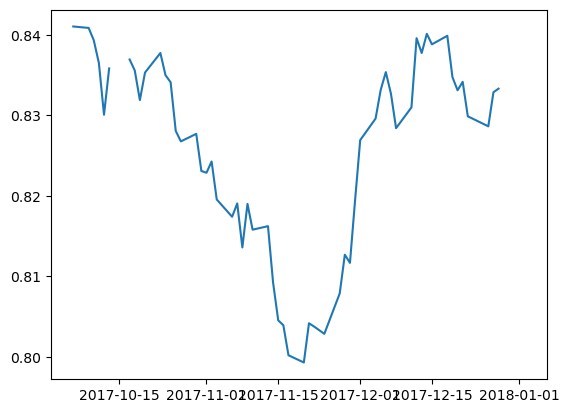

In [148]:
plt.plot((residual_df['BRK.B']+1).cumprod().tail(60))

In [138]:
(residual_df['WFC']+1).cumprod().tail(100)

date
2017-08-10    1.062898
2017-08-11    1.064959
2017-08-14    1.079149
2017-08-15    1.083704
2017-08-16    1.083990
                ...   
2017-12-26    1.124701
2017-12-27    1.121247
2017-12-28    1.124476
2017-12-29         NaN
2018-01-02    1.125428
Name: WFC, Length: 100, dtype: float64

In [143]:
price_df.loc[dt.datetime(2017,12,29)]

INCLF         NaN
NUE       55.2216
CAT      135.8250
VRSN     114.4400
CVC           NaN
           ...   
GILD      56.7431
WAI           NaN
EVHC      34.5600
NDAQ      23.2511
EOG       86.4308
Name: 2017-12-29 00:00:00, Length: 966, dtype: float64

In [ ]:
def preprocess_ou(data:np.array, lookback:int=60):
    signal_length = 4
    T,N = data.shape
    cumsums = np.cumsum(data, axis=0)
    windows = np.zeros((T-lookback, N, signal_length), dtype=np.float32)
    idxs_selected = np.zeros((T-lookback,N), dtype=bool)
    for t in range(lookback,T):
        # chooses stocks which have no missing returns in the t-th lookback window
        idxs_selected[t-lookback,:] = ~np.any(data[(t-lookback):t,:] == 0, axis=0).ravel() 
        idxs = idxs_selected[t-lookback,:]
        if t == lookback:
            x = cumsums[t-lookback:t,idxs].T
        else:
            # Probably unnecessary given the conv normalization, but is just to have the same setting as in the OU case
            x = cumsums[t-lookback:t,idxs].T - cumsums[t-lookback-1,idxs].reshape(int(sum(idxs)),1)
        Nx,Tx = x.shape
        #TODO: Is this where we make sure we dont have any look ahead bias?
        Ys = x[:,1:] #(N,T-1) 
        Xs = x[:,:-1]
        meansX = np.mean(Xs,axis=1) #(N)
        meansY = np.mean(Ys,axis=1)
        VarsX = np.var(Xs,axis=1) #N
        VarsY = np.var(Ys,axis=1)
        Covs = np.mean((Xs-meansX.reshape((Nx,1)))*(Ys-meansY.reshape((Nx,1))),axis=1) #N
        R2 = Covs**2/(VarsX*VarsY) #N
        bs = Covs/VarsX #N
        cs = (meansY - bs*meansX)
        mus = (cs/(1-bs+0.000001))
        mask = ((bs > 0) * (bs < 1))
        #kappas = -np.log(bs)/Deltat #if bs betwen 0 and 1
        residuals = Ys - bs.reshape((Nx,1))*Xs - cs.reshape((Nx,1)) #(N,T-1)
        sigmas = np.sqrt(np.var(residuals, axis=1)/np.abs(1-bs**2+0.000001)) #N
        signal = np.zeros((Nx))
        #signal =  (mus - Ys[:,-1])/sigmas * mask 
        signal[mask] = (mus[mask] - Ys[:,-1][mask])/sigmas[mask]
        windows[t-lookback,idxs,0] = Ys[:,-1]
        windows[t-lookback,idxs,1] = mus
        windows[t-lookback,idxs,2] = sigmas
        windows[t-lookback,idxs,3] = R2

        idxs_selected[t-lookback,idxs] = idxs_selected[t-lookback,idxs] & mask
        
    idxs_selected = torch.as_tensor(idxs_selected)
    return windows, idxs_selected

In [ ]:
def pca(returns:pd.DataFrame, res_cov_window_size:int = 252, loadings_window_size:int=60, amount_of_factors:int=5):
    '''
    Function that computes the percentage returns of a residual portfolio constructed using pca
    Also with the weights needed to construct all these portfolio's
    
    Residual_output  is a T x N matrix 
    Residual_portfolio is a T x N x N matrix where e.g res_portf[t,i, :] gives you the vector 
    with all the weights you need to construct the residual portfolio i at timestep t
    Recovering phi from residual portfolio can be done by slicing as follows res_portf[t,:,:]
    '''
    T, N                = returns.shape
    returns             = returns.to_numpy()
    residuals_output    = np.zeros((T, N), dtype=float)    
    residual_portfolio  = np.zeros((T, N, N), dtype=float)
    for t in tqdm(range(res_cov_window_size+1,len(returns))):
        # only use the columns with no missing values
        idxsSelected = ~np.any(np.isnan(returns[(t - res_cov_window_size+1):t]), axis = 0).ravel()   
        if idxsSelected.sum() == 0:
            continue
        #calculate covariance
        res_cov_window = returns[(t - res_cov_window_size+1):t,idxsSelected]
        R_oos           = returns[((t+1) - res_cov_window_size+1):(t+1),idxsSelected] #TODO: adj for bias, original returns[(t - res_cov_window_size+1):(t+1),idxsSelected]
        res_mean = np.mean(res_cov_window,axis=0,keepdims=True)
        res_vol = np.sqrt(np.mean((res_cov_window-res_mean)**2,axis=0,keepdims=True))
        res_normalized = (res_cov_window - res_mean) / res_vol
        Corr = np.dot(res_normalized.T, res_normalized)
        eigenValues, eigenVectors = np.linalg.eigh(Corr)

        #calculate loadings
        w           = eigenVectors[:,-amount_of_factors:].real                      # w
        R           = res_cov_window[-loadings_window_size:,:]
        wtR         = res_cov_window[-loadings_window_size:,:] @ w                  # R * w 
        regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)
        beta        = regr.coef_                                                    #beta
        phi         = (np.eye(beta.shape[0]) - beta @ w.T)
        #TODO: is ther somethign wrong with the returns they use here??
        residuals   = phi @ R_oos[-1,:].T
        residuals_output[t:(t+1),idxsSelected]                = residuals
        i = 0
        for idx, val in enumerate(idxsSelected):
            if val:  
                residual_portfolio[t:(t+1),idx,idxsSelected] = phi[i,:].reshape([1,-1])
                i += 1  
    return residuals_output, residual_portfolio

In [34]:
def pca_res_gen(price_data:pd.DataFrame, 
                amount_of_factors:int=5,
                loadings_window_size:int=60)-> np.ndarray:
    '''
    Calculates the pca portfolio given a dataset with prices
    '''

    T, N         = price_data.shape 
    assert loadings_window_size < T, 'loading window larger than length of dataset supplied' 

    rets         = price_data.pct_change(1,fill_method=None).iloc[1:].to_numpy()
    idxsSelected = ~np.any(np.isnan(rets), axis = 0).ravel()
    if idxsSelected.sum() == 0:
            return np.zeros((N,N))
    
    rets_is     = rets[:,idxsSelected] # in sample returns: used for generating the portfolio

    # Calculate PCA
    rets_mean   = np.mean(rets_is, axis=0,keepdims=True)
    rets_vol    = np.sqrt(np.mean((rets_is-rets_mean)**2,axis=0,keepdims=True))
    rets_normalized = (rets_is - rets_mean) / rets_vol
    Corr        = np.dot(rets_normalized.T, rets_normalized)
    _, eigenVectors = np.linalg.eigh(Corr)

    # Calculate loadings
    w           = eigenVectors[:,-amount_of_factors:].real  
    R           = rets_is[-loadings_window_size:,:]
    wtR         = R @ w  
    regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)
    beta        = regr.coef_                                                    #beta
    psi         = (np.eye(beta.shape[0]) - beta @ w.T)

    # Calculate residual returns
    residual_portf = np.zeros((N,N))
    i = 0
    for idx, val in enumerate(idxsSelected):
         if val:
               residual_portf[idx,idxsSelected] = psi[i,:].reshape([1,-1])
               i += 1
    return residual_portf, idxsSelected

In [ ]:
res_out, res_portf = pca(returns.loc[dt.datetime(2010,1,1):dt.datetime(2014,1,2)])

100%|██████████| 754/754 [00:45<00:00, 16.72it/s]


In [198]:
test_data = price_df.tail(252)

In [238]:
_, test = pca_res_gen(test_data)

In [232]:
price_df.index[10]

Timestamp('1996-01-16 00:00:00')

In [37]:
import gym
class TradingEnvironment(gym.Env):
    def __init__(self, 
                 financial_dataset:pd.DataFrame,
                 residual_generator,
                 signal_generator,
                 episode_length:int=100,
                 lookback_window:int=252,
                 signal_windows:int=60,
                 transaction_costs:float=0.0,
                 short_cost:float=0.0) -> None:
        '''
        financial_dataset: is a dataframe containing the adjusted prices of all the assets
        residual_generator: a function, called every timestep, whose input is a lookback window of asset prices, and then 
                            calculates the residual portfolios at that time.
        signal_generator:  a function, called every timestep, whose input is a lookback window of residual returns, that extracts 
                            the signal from the lookback window
        '''
        super().__init__()

        self.L, self.N = financial_dataset.shape # amount of datapoints, amount of stocks
        self.data      = financial_dataset  # dataset 
        self.returns   = financial_dataset.pct_change(1,fill_method=None) # compute returns 
        self.res_rets  = pd.DataFrame(index=self.data.index, columns=self.data.columns) # dataframe used to store the residual returns

        # both generic functions so they can be swapped in the future
        self.res_gen   = residual_generator 
        self.sig_gen   = signal_generator

        self.ep_N      = episode_length    # amount of timesteps until an 'episode' is over
        self.tc        = transaction_costs # transaction cost used
        self.sc        = short_cost        # cost to keep a short position
        self.lbw       = lookback_window   # lookback window used for pca 
        self.sig_win   = signal_windows    # lookback window used for signals

        self.t         = self.lbw + 1 #current timestep idx position in the large dataset
        self.ep        = 0  # current episode
        self.max_ep    = (self.L - self.lbw - self.sig_win) // self.ep_N # maximal amount of episodes possible with the data

        self.t_ep    = 0 # current timestep in the epsisode (max is self.ep_N)
        
        # reset the environment to begin
        self.warm_up()

    def warm_up(self):
        # if at initialisation
        assert self.ep == 0

        self.res_portf = np.zeros((self.N,self.N))
        for _ in range(self.sig_win):
            # start by computing the residual returns
            self.iter_step()
            self.res_rets_step()

            # calculate the residual portfolio weights at time t
            self.res_portf, self.active_stocks  = self.res_gen(self.data.iloc[self.t - self.lbw: self.t],
                                                        amount_of_factors=5,
                                                        loadings_window_size=60)
                
        observation = None #self.sig_gen(self.rets.iloc[self.t - self.sig_win:self.t])
        info = {'used_stocks': self.active_stocks}
        return observation, info
    
    def res_rets_step(self):
        self.res_portf_previous = self.res_portf.copy()
        self.res_rets.iloc[self.t,self.active_stocks] = (self.res_portf @ \
                        self.returns.iloc[self.t].replace(np.nan,0).values)[self.active_stocks]
        
    def iter_step(self):
        '''
        keeps track of all timesteps
        '''
        self.t    += 1
        self.t_ep += 1
        if self.t_ep >= self.ep_N:
            self.ep += 1

    def date(self):
        return self.data.index[self.t]

    def next_obs(self):
        # the the returns at time (t) from the residual portfolios generated at time (t-1)
        # generate the signal vector from the residual portfolio returns 
        # generate the new residual portfolios to trade in 
        None

    def calculate_transaction_cost(self):
        '''
        This calculation is based on the market friction model from Boyd et al. (2017)

        tc_vector contains the individual transaction costs incurred by trading in each of the portfolios
        tc_total is a real that contains the true total transaction cost incurred by the 
        '''
        tc_vector = self.tc * np.linalg.norm(self.new_alloc - self.old_alloc,1,axis=1) \
                        + self.sc * np.linalg.norm(np.minimum(self.new_alloc, np.zeros((self.N,self.N))))

        new_alloc_total = self.new_alloc.sum(axis=0) / np.norm(self.new_alloc.sum(axis=0),1)
        old_alloc_total = self.old_alloc.sum(axis=0) / np.norm(self.old_alloc.sum(axis=0),1)

        tc_total = self.tc * np.linalg.norm(new_alloc_total - old_alloc_total,1) \
                        + self.sc * np.linalg.norm(np.minimum(self.new_alloc_total, np.zeros(self.N)))
        return tc_vector, tc_total
    
    def step(self,action):
        '''
        Action is a vector of size N_t, the size of which can vary according to the active stocks at the time
        it represents the chosen loadings in the residual portfolios. 

        The reward will be a vector of the rewards generated by the individual portfolios and their allocation, and 
        will be be returned to the reinforcement learning agent as a reward signal.
        However, in the real environment there is a shared portfolio that will also be updated.
        '''
        assert len(action) == sum(self.active_stocks), 'wrong size of action/allocation vector supplied'
        # "invest" the chosen amount Action
        allocation_in_residuals = np.zeros((self.N,1))
        allocation_in_residuals[self.active_stocks] = action
        # calculate the new allocation in terms of the true asset space
        self.new_alloc = (self.res_portf * allocation_in_residuals[:,np.newaxis])
        # we incur a transaction cost through this new allocation
        self.tc_vector, self.tc_total = self.calculate_transaction_cost()

        # then we need to step
        self.iter_step()
        self.res_rets_step()
        
        # now calculate the effect of the allocation for each individual stock 
        portf_change = self.new_alloc @ self.returns.iloc[self.t, self.active_stocks].replace(np.nan,0).values
        reward      = portf_change - self.tc_vector

        # calculate the general profit made by the whole portfolio
        
        
        # when input with an action vector that is the residual portfolio allocation, normalize it,
        # Calculate what the allocation is in asset space, and finally computes 
        # 2: the general profit made by the whole portfolio
        self.old_alloc = self.new_alloc.copy()
        observation = self._get_next_obs()
        return observation, reward, done, info

In [53]:
price_df.iloc[:10].values.sum(axis=0).shape

(966,)

In [39]:
env = TradingEnvironment(financial_dataset=price_df,
                        residual_generator=pca_res_gen,
                        signal_generator=None,
                        episode_length=100,
                        lookback_window=252,
                        signal_windows=2,
                        transaction_costs=0.0)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 218 but corresponding boolean dimension is 966

In [24]:
env.date()

Timestamp('1997-01-03 00:00:00')

In [1]:
(6998 - 252) // 100

67

In [48]:
np.minimum(np.arange(-1,5),np.zeros(6))

array([-1.,  0.,  0.,  0.,  0.,  0.])

In [56]:
a = np.arange(-1,5).reshape(-1,1)[:,np.newaxis]

In [61]:
len(a)

6